This notebook demonstrates how to import the SHMS dataset, process it, and construct a simple model with the Keras API in order to filter tracks.

# Initialization

In [1]:
import uproot  # ROOT file manipulator

# Standard data science imports
import numpy as np
import pandas as ps
import matplotlib.pyplot as plt

import tensorflow as tf

# Keras API imports
from tensorflow.python.keras.models import Sequential, \
                                           load_model

from tensorflow.python.keras.layers import InputLayer, \
                                           Input, \
                                           Reshape, \
                                           MaxPooling1D, \
                                           Conv1D, \
                                           MaxPooling2D, \
                                           Conv2D, \
                                           Dense, \
                                           Flatten, \
                                           Dropout

from tensorflow.python.keras.optimizers import Adam

# Custom helper library imports
from pdc import particle_drift_chamber as PDC
import shms_helpers as shms

In [2]:
%matplotlib notebook

In [3]:
# Open ROOT file
file = uproot.open('/volatile/hallc/comm2017/mkjones/ROOTfiles/shms_coin_replay_production_all_4019_100000.root')
tree = file['T']

# Set data key prefixes so we don't have to type them every time
g = 'P.dc.gtrack.'
h = 'P.dc.hits.'

# Data Processing

In [4]:
# Collate parallel TBranch objects
hits_tracks   = shms.collate(tree[h + 'plane'], tree[h + 'time'], tree[h + 'wirenum'], validate=False)
gtrack_tracks = shms.collate(tree[g + 'plane'], tree[g + 'time'], tree[g + 'wirenum'], validate=False)

In [5]:
# Split into separate arrays for each PDC
h_tracks_pdc1 = [np.asarray([hit for hit in track if hit[0] < 7]) for track in hits_tracks]
h_tracks_pdc2 = [np.asarray([hit for hit in track if hit[0] > 6]) for track in hits_tracks]

g_tracks_pdc1 = [np.asarray([hit for hit in track if hit[0] < 7]) for track in gtrack_tracks]
g_tracks_pdc2 = [np.asarray([hit for hit in track if hit[0] > 6]) for track in gtrack_tracks]

In [6]:
# Remove empty tracks
non_empty_pairs1 = [pair for pair in zip(h_tracks_pdc1, g_tracks_pdc1) if len(pair[0]) > 0 or len(pair[1]) > 0]
non_empty_pairs2 = [pair for pair in zip(h_tracks_pdc2, g_tracks_pdc2) if len(pair[0]) > 0 or len(pair[1]) > 0]

h_tracks_pdc1 = [pair[0] for pair in non_empty_pairs1]
h_tracks_pdc2 = [pair[0] for pair in non_empty_pairs2]

g_tracks_pdc1 = [pair[1] for pair in non_empty_pairs1]
g_tracks_pdc2 = [pair[1] for pair in non_empty_pairs2]

In [7]:
# Convert wire hit arrays into 1D 'images' for input into the NN
onehot = False

h_tracks_images1 = [None] * len(h_tracks_pdc1)
h_tracks_images2 = [None] * len(h_tracks_pdc2)

g_tracks_images1 = [None] * len(g_tracks_pdc1)
g_tracks_images2 = [None] * len(g_tracks_pdc2)

for i, track in enumerate(h_tracks_pdc1):
    images = [np.zeros(PDC.numwires[k]) for k in range(0,6)]
    for hit in track:
        plane   = int(hit[0]) - 1  # python list indexing starts at 0, while plane numbering starts at 1
        time    =     hit[1]
        wirenum = int(hit[2]) - 1  # python list indexing starts at 0, while wire numbering starts at 1 (?)
        images[plane][wirenum] = 1.0 if onehot else time  # what function of time is best?
    h_tracks_images1[i] = np.concatenate(images)

for i, track in enumerate(h_tracks_pdc2):
    images = [np.zeros(PDC.numwires[k]) for k in range(6,12)]
    for hit in track:
        plane   = int(hit[0]) - 1 - 6
        time    =     hit[1]
        wirenum = int(hit[2]) - 1
        images[plane][wirenum] = 1.0 if onehot else time
    h_tracks_images2[i] = np.concatenate(images)

for i, track in enumerate(g_tracks_pdc1):
    images = [np.zeros(PDC.numwires[k]) for k in range(0,6)]
    for hit in track:
        plane   = int(hit[0]) - 1
        time    =     hit[1]
        wirenum = int(hit[2]) - 1
        images[plane][wirenum] = 1.0 if onehot else time
    g_tracks_images1[i] = np.concatenate(images)

for i, track in enumerate(g_tracks_pdc2):
    images = [np.zeros(PDC.numwires[k]) for k in range(6,12)]
    for hit in track:
        plane   = int(hit[0]) - 1 - 6
        time    =     hit[1]
        wirenum = int(hit[2]) - 1
        images[plane][wirenum] = 1.0 if onehot else time
    g_tracks_images2[i] = np.concatenate(images)

In [8]:
# Convert lists into numpy arrays
h_tracks_images1 = np.array(h_tracks_images1)
h_tracks_images2 = np.array(h_tracks_images2)
g_tracks_images1 = np.array(g_tracks_images1)
g_tracks_images2 = np.array(g_tracks_images2)

In [9]:
# Concatenate individual PDC arrays
h_tracks_pdc12 = np.concatenate((h_tracks_pdc1, h_tracks_pdc2))
g_tracks_pdc12 = np.concatenate((g_tracks_pdc1, g_tracks_pdc2))

In [10]:
# Concatenate individual image arrays
h_tracks_images12 = np.concatenate((h_tracks_images1, h_tracks_images2))
g_tracks_images12 = np.concatenate((g_tracks_images1, g_tracks_images2))

In [11]:
# Shuffle images arrays

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

h_tracks_images12, g_tracks_images12 = unison_shuffled_copies(h_tracks_images12, g_tracks_images12)

# Construct Keras Model

In [12]:
# Define constants
input_size = sum(PDC.numwires[0:6])
output_size = sum(PDC.numwires[0:6])

In [13]:
# Build model
model = Sequential([
    Dense(1024, activation='relu', input_dim=input_size),
    Dropout(0.2),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(output_size),
])

In [14]:
model.compile(
    optimizer=Adam(lr=1e-3),
    loss='mean_squared_error',
    metrics=['accuracy']
)

In [15]:
model.fit(
    x=h_tracks_images12[:140000],
    y=g_tracks_images12[:140000],
    epochs=100,
    batch_size=128,
    shuffle=True,
    verbose=1
)

Epoch 1/100
140000/140000 [==============================] - 73s 519us/step - loss: 32.4325 - acc: 0.1127
Epoch 2/100
140000/140000 [==============================] - 60s 429us/step - loss: 29.6502 - acc: 0.1682
Epoch 3/100
140000/140000 [==============================] - 60s 428us/step - loss: 28.0975 - acc: 0.1854
Epoch 4/100
140000/140000 [==============================] - 59s 418us/step - loss: 26.8859 - acc: 0.2057
Epoch 5/100
140000/140000 [==============================] - 59s 423us/step - loss: 25.7247 - acc: 0.2227
Epoch 6/100
140000/140000 [==============================] - 60s 428us/step - loss: 24.5736 - acc: 0.2375
Epoch 7/100
140000/140000 [==============================] - 60s 427us/step - loss: 23.9819 - acc: 0.2472
Epoch 8/100
140000/140000 [==============================] - 69s 492us/step - loss: 22.9576 - acc: 0.2550
Epoch 9/100
140000/140000 [==============================] - 70s 500us/step - loss: 22.6231 - acc: 0.2595
Epoch 10/100
140000/140000 [==================

In [16]:
result = model.evaluate(
    x=h_tracks_images12[140000:],
    y=g_tracks_images12[140000:]
)

print("accuracy: {0:.2%}".format(result[1]))

7865/7865 [==============================] - 2s 213us/step
accuracy: 35.42%


# Results Visualization

In [17]:
# Reset values of images arrays to unshuffle order of images
h_tracks_images12 = np.concatenate((h_tracks_images1, h_tracks_images2))
g_tracks_images12 = np.concatenate((g_tracks_images1, g_tracks_images2))

<IPython.core.display.Javascript object>


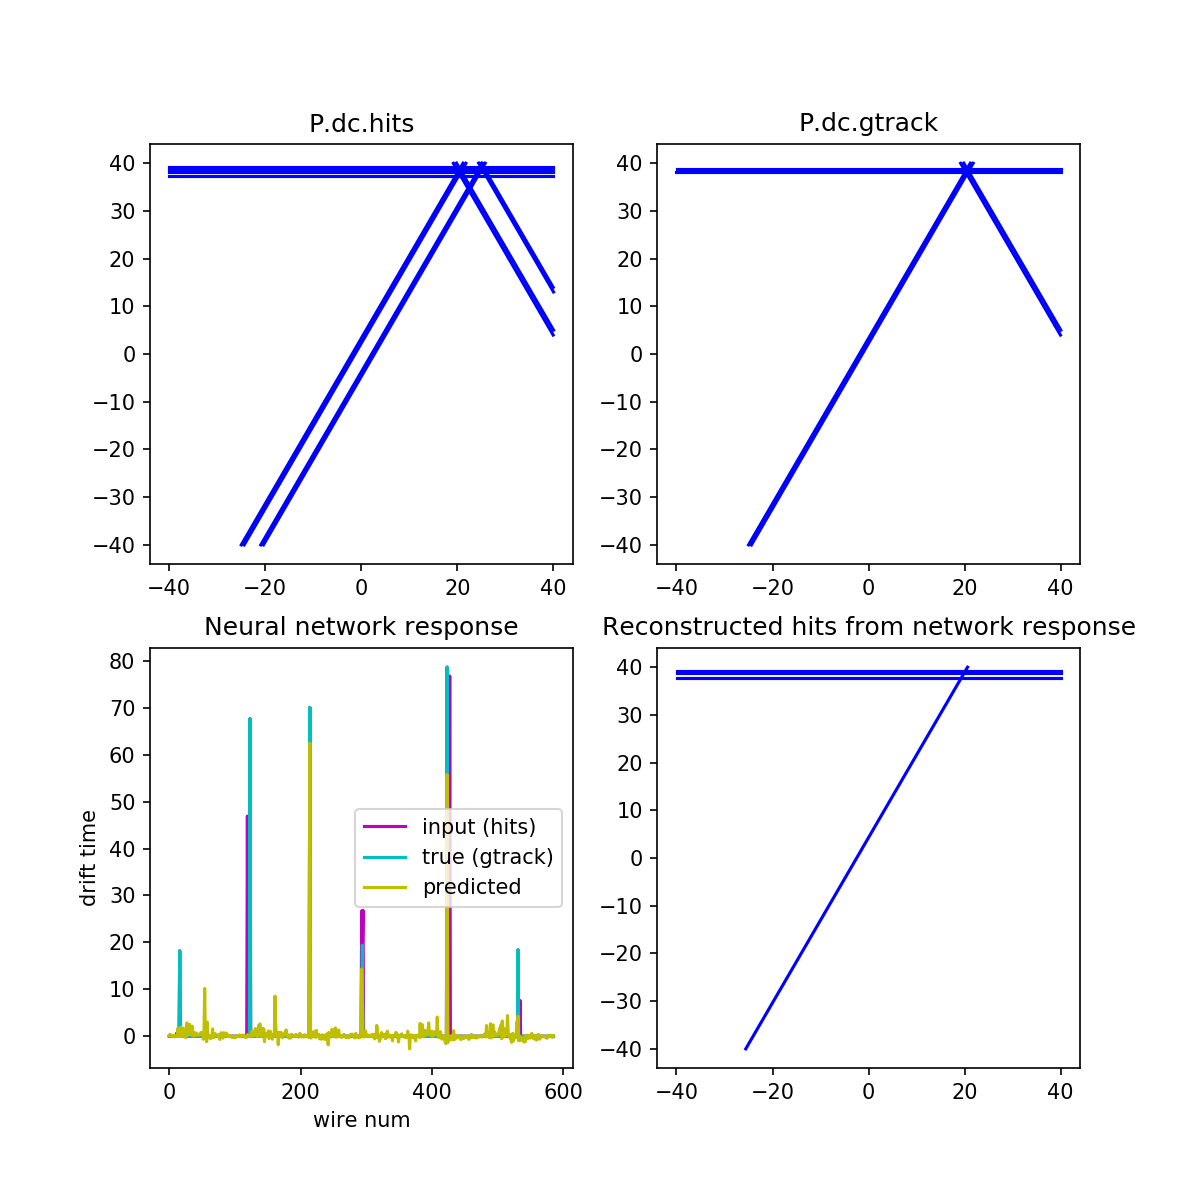

In [21]:
t = 140000 + 3673

fig_dim = 8
fig = plt.figure( figsize=(fig_dim, fig_dim) )

ax1 = plt.subplot(221)
plt.title( h[:-1] )
for hit in h_tracks_pdc12[t]:
    line = shms.hit_to_2d(hit)
    plt.plot(line[0], line[1], 'b')

ax2 = plt.subplot(222, sharex=ax1, sharey=ax1)  # sharex/sharey make subplots pan/zoom together
plt.title( g[:-1] )
for hit in g_tracks_pdc12[t]:
    line = shms.hit_to_2d(hit)
    plt.plot(line[0], line[1], 'b')

ax3 = plt.subplot(223)
plt.title('Neural network response')
plt.xlabel('wire num')
plt.ylabel('drift time')
plt.plot(h_tracks_images12[t], color='m', label='input (hits)')
plt.plot(g_tracks_images12[t], color='c', label='true (gtrack)')
plt.plot(model.predict(h_tracks_images12[t].reshape(1,input_size))[0], color='y', label='predicted')
plt.legend()

ax4 = plt.subplot(224, sharex=ax1, sharey=ax1)
plt.title('Reconstructed hits from network response')
clipped = [h_tracks_images12[t][i] if wire > 9 else 0.0 for i,wire in enumerate(model.predict(h_tracks_images12[t].reshape(1,input_size))[0])]
for i, time in enumerate(clipped):
    if time > 0:
        if i < sum(PDC.numwires[0:1]):
            line = shms.hit_to_2d((1, time, i+1))
        elif i < sum(PDC.numwires[0:2]):
            line = shms.hit_to_2d((2, time, i+1 - sum(PDC.numwires[0:1])))
        elif i < sum(PDC.numwires[0:3]):
            line = shms.hit_to_2d((3, time, i+1 - sum(PDC.numwires[0:2])))
        elif i < sum(PDC.numwires[0:4]):
            line = shms.hit_to_2d((4, time, i+1 - sum(PDC.numwires[0:3])))
        elif i < sum(PDC.numwires[0:5]):
            line = shms.hit_to_2d((5, time, i+1 - sum(PDC.numwires[0:4])))
        else:
            line = shms.hit_to_2d((6, time, i+1 - sum(PDC.numwires[0:5])))
        
        plt.plot(line[0], line[1], color='b')

plt.show()